In [1]:
import sys

sys.path.append('..')
from db import DB

key_prefix = 'adfr_pdbbind_'
keys = DB.keys(key_prefix + '*')
keys.sort()

In [2]:
DB.hgetall(keys[1])

{'error': 'False',
 'resolution': '2.2',
 'attempted': 'True',
 'PDB code': '10gs',
 'num_protein_atoms': '6695',
 'Kd/Ki': 'Ki=0.4uM',
 'release year': '1998',
 'ligand name': 'VWW',
 'finished': 'True',
 'top_adfr_predicted_affinity (kcal/mol)': '-11.0',
 'ligand_file': '/usr/project/dlab/Users/jaden/pdbbind/refined-set/10gs/10gs_ligand.mol2',
 'reference': '10gs.pdf',
 'total_atoms': '6754',
 '-logKd/Ki': '6.4',
 'num_ligand_atoms': '59',
 'output_log': '/usr/project/xtmp/yl708/adfr_benchmark_prepared/adfr_pdbbind_10gs_summary.dlg',
 'protein_file': '/usr/project/dlab/Users/jaden/pdbbind/refined-set/10gs/10gs_protein.pdb'}

In [3]:
from functional import seq
from tqdm import tqdm

results = seq(tqdm(keys)).map(lambda x: DB.hgetall(x)).list()

  0%|          | 0/5317 [00:00<?, ?it/s]

100%|██████████| 5317/5317 [00:06<00:00, 785.63it/s]


In [4]:
import pandas as pd

df = pd.DataFrame(results)

In [5]:
cleaned_df = df[df['top_adfr_predicted_affinity (kcal/mol)'].notna()]
cleaned_df

,attempted,finished,error,resolution,PDB code,num_protein_atoms,Kd/Ki,release year,ligand name,top_adfr_predicted_affinity (kcal/mol),ligand_file,reference,total_atoms,-logKd/Ki,num_ligand_atoms,output_log,protein_file
1,True,True,False,2.2,10gs,6695,Ki=0.4uM,1998,VWW,-11.0,/usr/project/dlab/Users/jaden/pdbbind/refined-...,10gs.pdf,6754,6.4,59,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
7,True,True,False,2.2,1a1e,3279,Kd=1uM,1998,4-mer,-11.6,/usr/project/dlab/Users/jaden/pdbbind/refined-...,1a1e.pdf,3352,6.0,73,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
9,True,True,False,2.0,1a30,3333,Ki=50uM,1998,3-mer,-8.4,/usr/project/dlab/Users/jaden/pdbbind/refined-...,1a30.pdf,3382,4.3,49,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
11,True,True,False,2.5,1a4r,6063,Kd=0.22uM,1999,GNH,-9.6,/usr/project/dlab/Users/jaden/pdbbind/refined-...,1a4r.pdf,6105,6.66,42,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
12,True,True,False,1.8,1a4w,4446,Ki=1.2uM,1998,QWE,-12.2,/usr/project/dlab/Users/jaden/pdbbind/refined-...,1a4w.pdf,4528,5.92,82,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5302,True,True,False,1.5,6udt,1698,Ki=0.1nM,2019,Q4V,-15.0,/usr/project/dlab/Users/jaden/pdbbind/refined-...,6ud2.pdf,1778,10.0,80,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
5303,True,True,False,1.75,6udu,1657,Ki=0.5nM,2019,Q4Y,-14.9,/usr/project/dlab/Users/jaden/pdbbind/refined-...,6ud2.pdf,1729,9.3,72,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
5304,True,True,False,1.35,6udv,1698,Ki=0.051nM,2019,Q51,-15.0,/usr/project/dlab/Users/jaden/pdbbind/refined-...,6ud2.pdf,1778,10.29,80,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...
5305,True,True,False,2.0,6ueg,7526,Kd=19.5uM,2019,Q5G,-6.7,/usr/project/dlab/Users/jaden/pdbbind/refined-...,6uec.pdf,7563,4.71,37,/usr/project/xtmp/yl708/adfr_benchmark_prepare...,/usr/project/dlab/Users/jaden/pdbbind/refined-...


In [6]:

import numpy as np

# Constants
R = 8.3144621 # J/(mol*K)
T = 298.15 # K

def delta_G_to_pKd(delta_G):
    """ delta_G in kcal/mol, pKd in M
    """
    return -delta_G * 1000 / (R * T * np.log(10)) * 4.184

def pKd_to_delta_G(pKd):
    """ pKd in M, delta_G in kcal/mol
    """
    return -pKd * R * T * np.log(10) / 1000 / 4.184

cleaned_df['experimental affinity (kcal/mol)'] = seq(cleaned_df['-logKd/Ki'].to_list()).map(lambda x: pKd_to_delta_G(float(x))).list()
cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] = cleaned_df['top_adfr_predicted_affinity (kcal/mol)'].astype(float)

/tmp/ipykernel_477553/1983999874.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['experimental affinity (kcal/mol)'] = seq(cleaned_df['-logKd/Ki'].to_list()).map(lambda x: pKd_to_delta_G(float(x))).list()
/tmp/ipykernel_477553/1983999874.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] = cleaned_df['top_adfr_predicted_affinity (kcal/mol)'].astype(float)


/tmp/ipykernel_477553/3285330606.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[cleaned_df['experimental affinity (kcal/mol)'] < 0][cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] < 0][cleaned_df['experimental affinity (kcal/mol)'] > -20][cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] > -20]
/tmp/ipykernel_477553/3285330606.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[cleaned_df['experimental affinity (kcal/mol)'] < 0][cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] < 0][cleaned_df['experimental affinity (kcal/mol)'] > -20][cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] > -20]


Spearman correlation: SignificanceResult(statistic=0.5129533989148064, pvalue=9.121136215494244e-141)


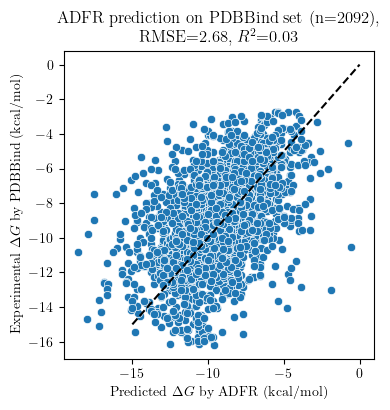

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy.stats as stats


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "figure.figsize": (4, 4),
})

cleaned_df = cleaned_df[cleaned_df['experimental affinity (kcal/mol)'] < 0][cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] < 0][cleaned_df['experimental affinity (kcal/mol)'] > -20][cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] > -20]

sns.scatterplot(data=cleaned_df, x='top_adfr_predicted_affinity (kcal/mol)', y='experimental affinity (kcal/mol)')

RMSE = np.sqrt(np.mean((cleaned_df['top_adfr_predicted_affinity (kcal/mol)'] - cleaned_df['experimental affinity (kcal/mol)'])**2))
R2 = r2_score(cleaned_df['experimental affinity (kcal/mol)'], cleaned_df['top_adfr_predicted_affinity (kcal/mol)'])


plt.plot([-15, 0], [-15, 0], color='black', linestyle='--')
plt.title(f'ADFR prediction on PDBBind set (n={len(cleaned_df)}),\nRMSE={RMSE:.2f}, $R^2$={R2:.2f}')

plt.xlabel(r'Predicted $\Delta G$ by ADFR (kcal/mol)')
plt.ylabel(r'Experimental $\Delta G$ by PDBBind (kcal/mol)')

print(f'Spearman correlation: {stats.spearmanr(cleaned_df["top_adfr_predicted_affinity (kcal/mol)"], cleaned_df["experimental affinity (kcal/mol)"])}')

plt.savefig('adfr_pdbbind.png', dpi=300, bbox_inches='tight')
